# Create A YouTube Name

## Scrape From Social Blade

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs

In [2]:
bad_url = r"https://socialblade.com/youtube/top/trending/bottom-500-channels-30-days/most-unsubscribed"
good_url = r"https://socialblade.com/youtube/top/trending/top-500-channels-30-days/most-subscribed"

In [3]:
def search_style(div, style_dict):
    """Search a HTML String for a given style"""
    div_style = div.get_attribute_list("style")[0]
    if div_style:
        style_pair_list = [[j.strip() for j in i.strip().split(":")] for i in div_style.split(";") if i.strip()]
        c_div_style_dict = {pair[0]:pair[1] for pair in style_pair_list}
        for k,v in style_dict.items():
            if k not in c_div_style_dict:
                return False
            if v != c_div_style_dict[k]:
                return False
        return True
    return False

In [4]:
def get_details(row):
    """Pass row of HTML from SocialBlade Table, return Tuple of Name, Subs, Views"""
    name = row.find_all("a")[0].string
    stats = [c_div for c_div in row.find_all("div") if search_style(c_div, {"width":"150px"})]
    subs, views = [int(c_stat.text.strip().replace(",","").replace("--", "0")) for c_stat in stats]
    return name, subs, views

In [5]:
def get_socialblade(url):
    """Pass SpcialBlade URL, return pandas DataFrame of data"""
    # TargetStyle is the normal width of the SocialBlade data table
    target_style = {"width":"860px"}
    
    results = requests.get(url)
    content = results.content
    soup = bs(content, "html.parser")
    divs = soup.find_all("div")
    rows = [c_div for c_div in divs if search_style(c_div, target_style)][2:]
    table_data = [get_details(c_row) for c_row in rows]
    return pd.DataFrame(table_data, columns = ["Name", "Subs", "Views"])

## Prepare Names for NN

In [6]:
import numpy as np

In [7]:
def gen_valid_chars():
    letters = "abcdefghijklmnopqrstuvwxyz"
    letters += letters.upper()
    special_chars = r" !@#$%^&*()_+-={}[]:;<,>.?/\`~'" + '"'
    numbers = "".join([str(i) for i in range(10)])
    valid_chars = letters + special_chars + numbers
    return valid_chars

In [8]:
def encode(string, valid_chars = None, max_len=36):
    """Convert a string into a matrix of one-hot encoded character vectors"""
    if not valid_chars:
        valid_chars = gen_valid_chars()
    valid_char_ct = len(valid_chars)
    
    output = []
    for i in string:
        c_letter = np.zeros(valid_char_ct)
        c_letter[valid_chars.index(i)] = 1
        output.append(c_letter)
    while len(output)<max_len:
        output.append(np.zeros(valid_char_ct))
    return np.array(output)

In [9]:
def decode(input_matrix, valid_chars = None):
    """Convert a matrix of one-hot encoded character vectors into a string"""
    if not valid_chars:
        valid_chars = gen_valid_chars()
    output = ""
    for i in input_matrix:
        try:
            index = np.where(i==1)[0][0]
        except IndexError:
            return output
        output += valid_chars[index]
    return output

## Prepare Dataset for NN

In [10]:
class myData():
    def __init__(self, urls, train_pct=.9, filter_df=True, valid_chars = None):
        """Scrape data from socialblade and split into train/test for NN"""
        if not valid_chars:
            valid_chars = gen_valid_chars()
        self.valid_chars = valid_chars
        
        for index, c_url in enumerate(urls):
            if index == 0:
                self.data = get_socialblade(c_url)
            else:
                self.data = pd.concat([self.data, get_socialblade(c_url)], ignore_index=True)
                
        if filter_df:
            self.data = self.data[[all([i in self.valid_chars for i in name]) for name in self.data["Name"]]]
            
        self.data["encoded"] = self.data.apply(lambda row: encode(row["Name"]), axis=1)
        self.train = self.data.sample(frac=train_pct)
        self.test = self.data[[i not in self.train.index for i in self.data.index]]

In [11]:
socialblade_data = myData([good_url, bad_url])

In [12]:
len(socialblade_data.train)

794

In [13]:
len(socialblade_data.test)

88

In [14]:
socialblade_data.data.head(5)

,Name,Subs,Views,encoded
0,Santa Songs,4920612,-1083152840,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,T-Series,4311135,2952989962,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,PewDiePie,4193944,337501746,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Marshmello,3928773,560652204,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,Cocomelon - Nursery Rhymes,3423439,2632558586,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [15]:
t = socialblade_data.data.encoded[0]

In [16]:
decode(t)

'Santa Songs'

In [17]:
t.shape

(36, 94)

## Build NN Arch

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [19]:
from time import time

In [20]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, input_col, label_col, batch_size = 32, shuffle=True, name=""):
        self.data = data
        self.batch_size = batch_size
        self.input_col = input_col
        self.label_col = label_col
        self.indecies = [i for i in range(len(data))]
        self.shuffle = shuffle
        self.batch_no = 0
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, c_index):
        'Generate one batch of data'
        # Generate indexes of the batch
        batch_rows = self.indecies[c_index*self.batch_size:(c_index+1)*self.batch_size]

        # Generate data
        inputs, labels = self.__data_generation(batch_rows)

        return inputs, labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indecies)

    def __data_generation(self, rows):
        input_lst = []
        label_lst = []
        for i in rows:
            input_lst.append(self.data.iloc[i][self.input_col])
            label_lst.append(self.data.iloc[i][self.label_col])
        return np.asarray(input_lst), np.asarray(label_lst)


In [21]:
training_generator = DataGenerator(socialblade_data.train, "encoded", "Views", batch_size = 32, shuffle=True, name="train")
validation_generator = DataGenerator(socialblade_data.test, "encoded", "Views", batch_size = 32, shuffle=True, name="test")

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

In [22]:
model = Sequential()
model.add(Dense(36*94, input_shape=(36,94), activation="relu"))
model.add(Flatten())
model.add(Dense(int(36*94/3), activation="relu"))
model.add(Dense(int(36*94/6), activation="relu"))
model.add(Dense(int(36*94/12), activation="relu"))
model.add(Dense(int(36*94/18), activation="relu"))
model.add(Dense(int(94), activation="relu"))
model.add(Dense(int(94/2), activation="relu"))
model.add(Dense(1, activation="linear"))

In [23]:
model.compile(loss='mse', optimizer='adam')
tensorboard = TensorBoard(log_dir = "logs/{}".format(time()))

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [43]:
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=150,
    callbacks=[tensorboard]
)

Epoch 1/150
24/24 [==============================] - 4s 147ms/step - loss: 53138797106648400.0000 - val_loss: 15251633147478016.0000
Epoch 2/150
24/24 [==============================] - 3s 145ms/step - loss: 45260390575811240.0000 - val_loss: 11164979549962240.0000
Epoch 3/150
24/24 [==============================] - 4s 146ms/step - loss: 50570502047705776.0000 - val_loss: 13677117732552704.0000
Epoch 4/150
24/24 [==============================] - 4s 147ms/step - loss: 50987373318286000.0000 - val_loss: 16907060914421760.0000
Epoch 5/150
24/24 [==============================] - 3s 144ms/step - loss: 51704760430668464.0000 - val_loss: 14421473145913344.0000
Epoch 6/150
24/24 [==============================] - 3s 145ms/step - loss: 52631750425182208.0000 - val_loss: 16387167739707392.0000
Epoch 7/150
24/24 [==============================] - 3s 144ms/step - loss: 52715164125888512.0000 - val_loss: 13568446470029312.0000
Epoch 8/150
24/24 [==============================] - 4s 147ms/step - 

Epoch 62/150
24/24 [==============================] - 3s 146ms/step - loss: 3747506800994987.0000 - val_loss: 16458453190967296.0000
Epoch 63/150
24/24 [==============================] - 3s 145ms/step - loss: 2972753331574101.0000 - val_loss: 17445457076682752.0000
Epoch 64/150
24/24 [==============================] - 3s 145ms/step - loss: 2865718297799338.5000 - val_loss: 22985212732375040.0000
Epoch 65/150
24/24 [==============================] - 3s 145ms/step - loss: 3042358684461739.0000 - val_loss: 36216794179960832.0000
Epoch 66/150
24/24 [==============================] - 3s 145ms/step - loss: 3390888161400149.0000 - val_loss: 25362044949626880.0000
Epoch 67/150
24/24 [==============================] - 3s 145ms/step - loss: 3658606335492096.0000 - val_loss: 22640817021648896.0000
Epoch 68/150
24/24 [==============================] - 3s 143ms/step - loss: 3795765920355669.0000 - val_loss: 16156120242454528.0000
Epoch 69/150
24/24 [==============================] - 3s 144ms/step -

24/24 [==============================] - 3s 133ms/step - loss: 870360239745706.7500 - val_loss: 20415982086389760.0000
Epoch 124/150
24/24 [==============================] - 3s 134ms/step - loss: 890265564523178.7500 - val_loss: 26098603923603456.0000
Epoch 125/150
24/24 [==============================] - 3s 132ms/step - loss: 821140538086741.2500 - val_loss: 23811344859922432.0000
Epoch 126/150
24/24 [==============================] - 3s 132ms/step - loss: 871237951684608.0000 - val_loss: 18532978229510144.0000
Epoch 127/150
24/24 [==============================] - 3s 133ms/step - loss: 845221889135957.2500 - val_loss: 21243842401402880.0000
Epoch 128/150
24/24 [==============================] - 3s 133ms/step - loss: 816723241118378.7500 - val_loss: 23065820678586368.0000
Epoch 129/150
24/24 [==============================] - 3s 132ms/step - loss: 808289208806058.7500 - val_loss: 32308240796614656.0000
Epoch 130/150
24/24 [==============================] - 3s 133ms/step - loss: 708433

In [25]:
import matplotlib.pyplot as plt

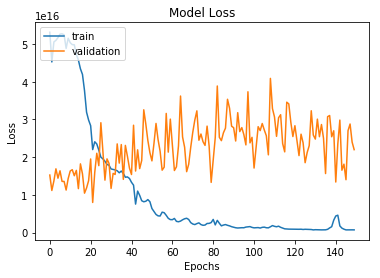

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc='upper left')
plt.show()

In [45]:
encode("Data DIY")

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
def predict_it(string, model=model):
    return int(model.predict(np.asarray([encode(string)]))[0][0])

In [47]:
predict_it("Data DIY")

19673538

In [48]:
predict_it("DIY Data")

88245648

In [50]:
socialblade_data.data["prediction"] = socialblade_data.data.apply(lambda row: predict_it(row["Name"]), axis=1)

In [51]:
socialblade_data.data

,Name,Subs,Views,encoded,prediction
0,Santa Songs,4920612,-1083152840,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-1058296512
2,T-Series,4311135,2952989962,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2982183936
3,PewDiePie,4193944,337501746,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",341678208
4,Marshmello,3928773,560652204,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",575171264
5,Cocomelon - Nursery Rhymes,3423439,2632558586,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2669704960
6,Nilson Izaias Papinho Oficial,3155334,38731993,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",38466660
7,GNP Music,2813501,52209193,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",54740824
8,IND News,2610298,122944794,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",88795696
10,ABP NEWS HINDI,2468095,229152417,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",230561664
11,5-Minute Crafts,2430865,573132474,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",574108800
